In [1]:
import toml
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('ticks')
sns.set_context('talk')

In [3]:
def distmod(z_helio, z_CMB):
    model_mu = (5./np.log(10.))*np.log((1. + z_helio) * (1.00038*z_CMB - 0.227753*np.exp(np.log(z_CMB)*2) - 0.0440361*np.exp(np.log(z_CMB)*3) + 0.0619502*np.exp(np.log(z_CMB)*4) -  0.0220087*np.exp(np.log(z_CMB)*5) + 0.00289242*np.exp(np.log(z_CMB)*6)  )) + 43.1586133146;
    return model_mu

# Parse data files

## SNEMO7

In [4]:
snemo7_data = pickle.load(open('snemo7_02.pkl', 'rb'))
snemo7_sne = np.array(toml.load('snemo7_02_err_lt2.0.txt')['names'])
snemo7_results = pd.read_csv('snemo7_02_err_lt2.0_results.txt',
                             delim_whitespace=True, skiprows=4, skipfooter=6, engine='python')

snemo7_cut = np.array([x in snemo7_sne for x in snemo7_data['names']])
snemo7_out_cut = np.array([i-1 for i in range(1, len(snemo7_sne)+1) if snemo7_results.loc['outl_loglike[{}]'.format(i)]['mean']>0])
snemo7_zhel = snemo7_data['z_helio'][snemo7_cut]
snemo7_zcmb = snemo7_data['z_CMB'][snemo7_cut]
snemo7_obs = snemo7_data['obs_mBx1c'][snemo7_cut]

## SALT2

In [5]:
salt2_data = pickle.load(open('salt2_00.pkl', 'rb'))
salt2_sne = np.array(toml.load('salt2_00_passed_snemo7_02.txt')['names'])
salt2_results = pd.read_csv('salt2_00_passed_snemo7_02_results.txt',
                            delim_whitespace=True, skiprows=4, skipfooter=6, engine='python')

salt2_cut = [x in salt2_sne for x in salt2_data['names']]
salt2_out_cut = np.array([i-1 for i in range(1, len(salt2_sne)+1) if salt2_results.loc['outl_loglike[{}]'.format(i)]['mean']>0])
salt2_zhel = salt2_data['z_helio'][salt2_cut]
salt2_zcmb = salt2_data['z_CMB'][salt2_cut]
salt2_obs = salt2_data['obs_mBx1c'][salt2_cut]

## Un-standardized Hubble-Lemaître diagram

Text(0, 0.5, 'Residual')

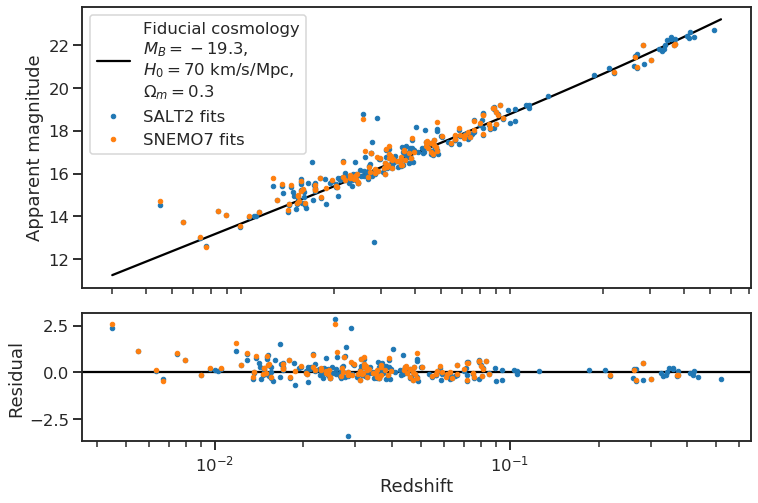

In [6]:
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)
z = np.linspace(0.003, 0.55)
ax1.plot(z, distmod(z, z) - 19.3, color='k', label='Fiducial cosmology\n$M_B=-19.3$,\n$H_0=70$ km/s/Mpc,\n$\Omega_m=0.3$')
ax1.plot(salt2_zcmb, salt2_obs[:, 0], '.', color='C0', label='SALT2 fits')
ax1.plot(snemo7_zcmb, snemo7_obs[:, 0], '.', color='C1', label='SNEMO7 fits')
ax1.set_xscale('log')
ax1.set_ylabel('Apparent magnitude')
ax1.set_xticks([])
ax1.legend()

ax2.axhline(0, color='k')
ax2.plot(salt2_zcmb, salt2_obs[:, 0] - distmod(salt2_zhel, salt2_zcmb) + 19.3, '.', color='C0')
ax2.plot(snemo7_zcmb, snemo7_obs[:, 0] - distmod(snemo7_zhel, snemo7_zcmb) + 19.3, '.', color='C1')
ax2.set_xscale('log')
ax2.set_xlabel('Redshift')
ax2.set_ylabel('Residual')

# Calculate distances

$$\mu = m_B^* - [M_B + \alpha x_1 + \beta c + \gamma \log_{10}(M_\odot)]$$

In [7]:
snemo7_mu = snemo7_obs[:, 0] - snemo7_results['mean'].loc['MB[1]']
for i in range(1, 9):
    snemo7_mu -= snemo7_obs[:, i] * snemo7_results['mean'].loc['coeff[{}]'.format(i)]
snemo7_mu -= np.mean(snemo7_mu - distmod(snemo7_zhel, snemo7_zcmb), axis=0)

In [8]:
salt2_mu = salt2_obs[:, 0] - salt2_results['mean'].loc['MB[1]']
for i in range(1, 4):
    salt2_mu -= salt2_obs[:, i] * salt2_results['mean'].loc['coeff[{}]'.format(i)]
salt2_mu -= np.mean(salt2_mu - distmod(salt2_zhel, salt2_zcmb), axis=0)

(-1, 1)

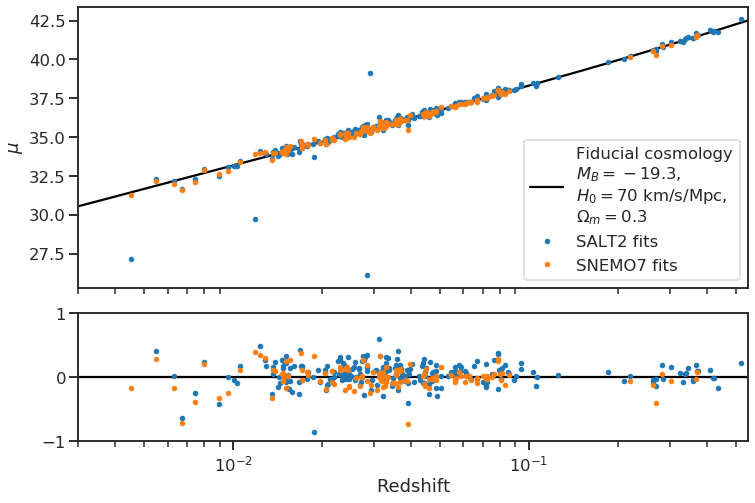

In [9]:
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)

ax1.plot(z, distmod(z, z), 'k', label='Fiducial cosmology\n$M_B=-19.3$,\n$H_0=70$ km/s/Mpc,\n$\Omega_m=0.3$')
ax1.plot(salt2_zcmb, salt2_mu, '.', label='SALT2 fits')
ax1.plot(snemo7_zcmb, snemo7_mu, '.', label='SNEMO7 fits')
ax1.legend()
ax1.set_xscale('log')
ax1.set_xticks([])
ax1.set_ylabel('$\mu$')
ax1.set_xlim(0.003, 0.55)

ax2.axhline(0, color='k')
ax2.plot(salt2_zcmb, salt2_mu-distmod(salt2_zhel, salt2_zcmb), '.')
ax2.plot(snemo7_zcmb, snemo7_mu-distmod(snemo7_zhel, snemo7_zcmb), '.')
ax2.set_xlabel('Redshift')
ax2.set_xscale('log')
ax2.set_xlim(0.003, 0.55)
ax2.set_ylim(-1, 1)

# Compare distances

In [10]:
data = {'name': [],
        'zhel': [],
        'zcmb': [],
        'snemo7_mu': [],
        'salt2_mu': [],
        'outlier_like': [],
        'snemo7_outlier_like': []}
for i, name in enumerate(salt2_sne):
    data['name'].append(name)
    data['zhel'].append(salt2_zhel[i])
    data['zcmb'].append(salt2_zcmb[i])
    data['salt2_mu'].append(salt2_mu[i])
    if name in snemo7_sne:
        data['snemo7_mu'].append(snemo7_mu[list(snemo7_sne).index(name)])
        data['snemo7_outlier_like'].append(snemo7_results.loc['outl_loglike[{}]'.format(list(snemo7_sne).index(name)+1)]['mean'])
    else:
        data['snemo7_mu'].append(np.nan)
        data['snemo7_outlier_like'].append(np.nan)
    data['outlier_like'].append(salt2_results.loc['outl_loglike[{}]'.format(i+1)]['mean'])

df = pd.DataFrame(data)

In [11]:
df.head()

,name,zhel,zcmb,snemo7_mu,salt2_mu,outlier_like,snemo7_outlier_like
0,05D4bm,0.372000,0.370511,41.576428,41.594047,4.77,4.64
1,SN2004s,0.009370,0.010291,NaN,33.150784,4.37,NaN
2,SN2005ms,0.025204,0.026567,NaN,35.451710,4.72,NaN
3,06D2fb,0.124000,0.125298,NaN,38.874331,4.78,NaN
4,SN2004ey,0.015800,0.014633,34.065979,34.281120,3.99,4.78


In [12]:
no_out_df = df[(df.outlier_like>0) & ((df.snemo7_outlier_like>0) | np.isnan(df.snemo7_outlier_like)) & (np.abs(salt2_obs[:, 1]) < 10)]

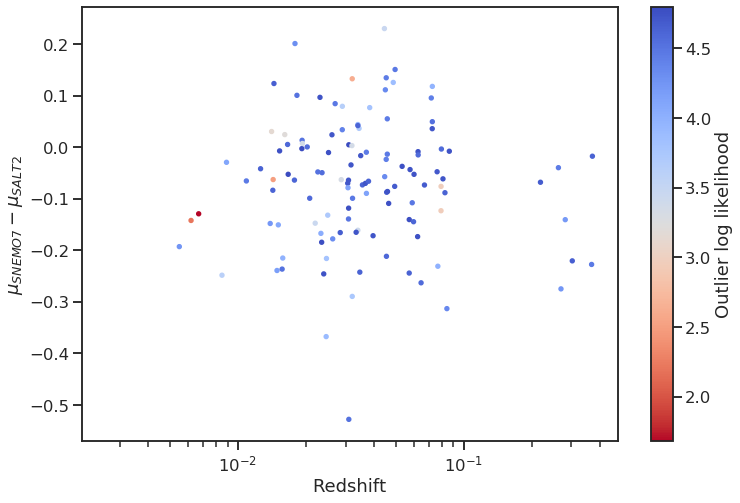

In [13]:
plt.figure(figsize=(12, 8))
plt.scatter(no_out_df.zhel, no_out_df.snemo7_mu - no_out_df.salt2_mu,
            c=np.minimum(no_out_df.outlier_like, no_out_df.snemo7_outlier_like), cmap='coolwarm_r', s=15)
plt.xscale('log')
plt.xlabel('Redshift')
plt.ylabel('$\mu_{SNEMO7} - \mu_{SALT2}$')
plt.colorbar(label='Outlier log likelihood')

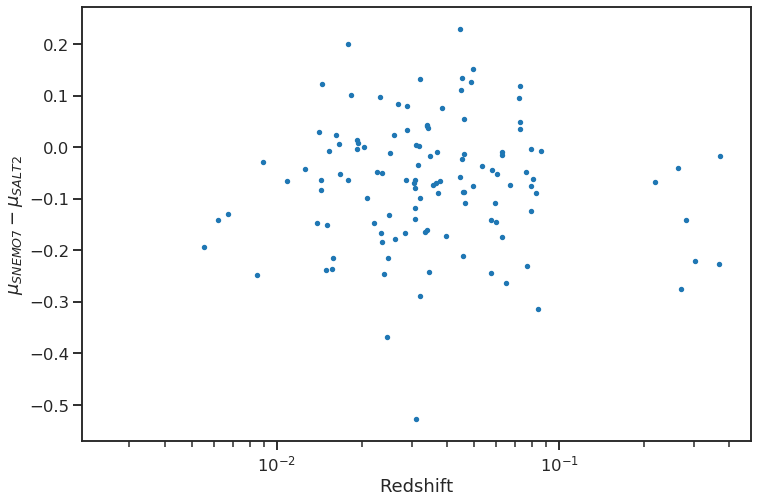

In [18]:
plt.figure(figsize=(12, 8))
plt.scatter(no_out_df.zhel, no_out_df.snemo7_mu - no_out_df.salt2_mu, s=15)
plt.xscale('log')
plt.xlabel('Redshift')
plt.ylabel('$\mu_{SNEMO7} - \mu_{SALT2}$')
# plt.ylim(-0.7, 0.7)
# plt.colorbar(label='Outlier log likelihood')
plt.savefig('distance_differences_vs_z.pdf', bbox_inches='tight')

(array([ 1.,  0.,  2., 11., 14., 25., 35., 16., 12.,  2.]),
 array([-0.52801568, -0.45221895, -0.37642221, -0.30062548, -0.22482875,
        -0.14903202, -0.07323529,  0.00256144,  0.07835817,  0.1541549 ,
         0.22995164]),
 <a list of 10 Patch objects>)

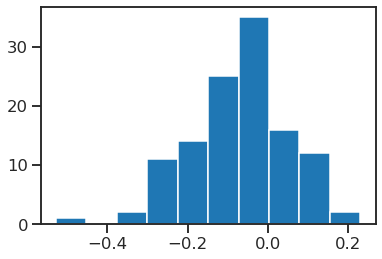

In [15]:
plt.hist(no_out_df.dropna().snemo7_mu - no_out_df.dropna().salt2_mu)

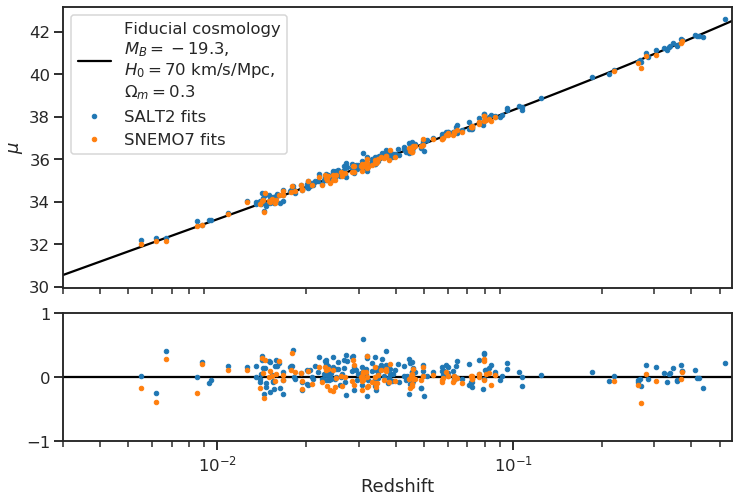

In [17]:
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)

ax1.plot(z, distmod(z, z), 'k', label='Fiducial cosmology\n$M_B=-19.3$,\n$H_0=70$ km/s/Mpc,\n$\Omega_m=0.3$')
ax1.plot(no_out_df.zhel, no_out_df.salt2_mu, '.', label='SALT2 fits')
ax1.plot(no_out_df.zhel, no_out_df.snemo7_mu, '.', label='SNEMO7 fits')
ax1.legend()
ax1.set_xscale('log')
ax1.set_xticks([])
ax1.set_ylabel('$\mu$')
ax1.set_xlim(0.003, 0.55)

ax2.axhline(0, color='k')
ax2.plot(no_out_df.zhel, no_out_df.salt2_mu-distmod(no_out_df.zhel, no_out_df.zcmb), '.')
ax2.plot(no_out_df.zhel, no_out_df.snemo7_mu-distmod(no_out_df.zhel, no_out_df.zcmb), '.')
ax2.set_xlabel('Redshift')
ax2.set_xscale('log')
ax2.set_xlim(0.003, 0.55)
ax2.set_ylim(-1, 1)
plt.savefig('hubble_diagram.pdf', bbox_inches='tight')